Net GHG/Revenue Impact of Load-Shifting Batteries

In [1]:
import os, sys
PWD = os.getenv('PWD')
os.chdir(PWD)
sys.path.insert(0, os.getenv('PWD'))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "local_settings.py")
import django
django.setup()

In [2]:
from datetime import datetime, timedelta

from beo_datastore.libs.battery import Battery
from beo_datastore.libs.battery_schedule import create_fixed_schedule, optimize_battery_schedule
from beo_datastore.libs.plot_intervalframe import (
        plot_frame288, plot_frame288_monthly_comparison, plot_intervalframe, plot_many_frame288s
)

from cost.ghg.models import GHGRate
from cost.optimization.models import MultiScenarioOptimization, SimulationOptimization
from cost.utility_rate.models import RatePlan
from der.simulation.models import BatteryConfiguration, BatterySchedule, BatteryStrategy
from load.customer.models import Meter
from reference.reference_model.models import LoadServingEntity

In [3]:
# define battery specs and schedule

# create 5 kW @ 2 hours battery with 90% efficiency
battery = Battery(rating=5, discharge_duration=timedelta(hours=2), efficiency=0.9)
config_1, _ = BatteryConfiguration.get_or_create_from_battery(battery)

# create 10 kW @ 2 hours battery with 90% efficiency
battery = Battery(rating=10, discharge_duration=timedelta(hours=2), efficiency=0.86)
config_2, _ = BatteryConfiguration.get_or_create_from_battery(battery)

configs = [config_1, config_2]

In [4]:
load_serving_entity = LoadServingEntity.objects.get(name__contains="MCE")
rate_plan_name = "EV"
rate_plan = RatePlan.objects.get(name__contains=rate_plan_name, load_serving_entity=load_serving_entity)

# only charge on NEM exports
charge_schedule_1, _ = BatterySchedule.get_or_create_from_frame288(frame288=create_fixed_schedule(0, 0, 0, 0))
# always discharge between 4 p.m. and 9 p.m.
discharge_schedule_1, _ = BatterySchedule.get_or_create_from_frame288(frame288=create_fixed_schedule(16, 22, 0, float("inf")))
strategy_1, _ = BatteryStrategy.objects.get_or_create(
    charge_schedule=charge_schedule_1,
    discharge_schedule=discharge_schedule_1,
)
strategy_1.name = "Flatten Evening Peak with PV Exports"
strategy_1.save()

# define optimized Clean Net Short 2030 charge/discharge schedule
ghg_rate = GHGRate.objects.get(name="Clean Net Short", effective__year=2030)
strategy_2 = BatteryStrategy.generate(
    frame288_name=ghg_rate.name,
    frame288=ghg_rate.frame288,
    level=10,  # choose 10 lowest/highest GHG rates
    threshold=0,  # do not charge from grid or discharge to grid
)

# define optimized utility bill charge/discharge schedule
rate_plan_frame288 = rate_plan.get_rate_frame288_by_year(2018, "energy", "weekday")
strategy_3 = BatteryStrategy.generate(
    frame288_name="{} Energy Weekday".format(rate_plan_name),
    frame288=rate_plan_frame288,
    level=1,  # choose 1 lowest/highest utility rates
    threshold=None,  # allow charging to and discharging from grid
)

strategies = [strategy_1, strategy_2, strategy_3]

# view schedules
# display(rate_plan_frame288.dataframe)
# display(strategy_3.charge_schedule.frame288.dataframe)
# display(strategy_3.discharge_schedule.frame288.dataframe)

In [5]:
# create multi-scenario optimization
multi = MultiScenarioOptimization.objects.create()

# run simulation optimization
for config in configs:
    for strategy in strategies:
        single, _ = SimulationOptimization.objects.get_or_create(
            start=datetime(2018, 1, 1),
            end_limit=datetime(2019, 1, 1),
            battery_strategy=strategy,
            battery_configuration=config,
            rate_plan=rate_plan,
        )
        single.meters.add(*Meter.objects.filter(load_serving_entity=load_serving_entity))
        single.ghg_rates.add(*GHGRate.objects.filter(name="Clean Net Short"))
        single.ghg_rates.add(*GHGRate.objects.filter(name="CARB - Unspecified Power"))
        multi.simulation_optimizations.add(single)

multi.run(multiprocess=True)

In [6]:
# display bill and GHG impacts
display(multi.detailed_report)

,BillDelta,CleanNetShort2018Delta,CleanNetShort2022Delta,CleanNetShort2026Delta,CleanNetShort2030Delta,CARB-UnspecifiedPower2013Delta,SimulationOptimization,BatteryConfiguration,BatteryStrategy,SimulationRatePlan,MeterRatePlan
SA_ID,,,,,,,,,,,
0,-36.212045,0.009779,-0.031470,-0.023757,-0.107685,0.016451,1,5kW @ 2 hours (90.0% efficiency),Flatten Evening Peak with PV Exports,"EV, Residential Rates for Electric Vehicle Owners",TEST
0,-657.102068,0.537030,1.716270,1.460161,2.068619,0.518272,10,10kW @ 2 hours (86.0% efficiency),Minimize using EV Energy Weekday (level: 1),"EV, Residential Rates for Electric Vehicle Owners",TEST
0,-33.650985,0.015926,-0.025513,-0.017664,-0.101805,0.023154,4,10kW @ 2 hours (86.0% efficiency),Flatten Evening Peak with PV Exports,"EV, Residential Rates for Electric Vehicle Owners",TEST
0,-35.124545,0.010740,-0.035532,-0.024358,-0.113171,0.016248,7,5kW @ 2 hours (90.0% efficiency),Minimize using Clean Net Short with 0kW thresh...,"EV, Residential Rates for Electric Vehicle Owners",TEST
0,-333.255259,0.195219,0.783675,0.656730,0.963762,0.178028,8,5kW @ 2 hours (90.0% efficiency),Minimize using EV Energy Weekday (level: 1),"EV, Residential Rates for Electric Vehicle Owners",TEST
0,-32.652615,0.016770,-0.029564,-0.018344,-0.107200,0.022869,9,10kW @ 2 hours (86.0% efficiency),Minimize using Clean Net Short with 0kW thresh...,"EV, Residential Rates for Electric Vehicle Owners",TEST
7720534682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,5kW @ 2 hours (90.0% efficiency),Flatten Evening Peak with PV Exports,"EV, Residential Rates for Electric Vehicle Owners","E19, Medium General Service, Primary"
7720534682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,10kW @ 2 hours (86.0% efficiency),Flatten Evening Peak with PV Exports,"EV, Residential Rates for Electric Vehicle Owners","E19, Medium General Service, Primary"
7720534682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,5kW @ 2 hours (90.0% efficiency),Minimize using Clean Net Short with 0kW thresh...,"EV, Residential Rates for Electric Vehicle Owners","E19, Medium General Service, Primary"


In [7]:
# remove all existing filters
multi.reinitialize()

# filter simulations
multi.filter_by_query("BillDelta < 0")  # include only BillDelta < -0
multi.filter_by_transform("CleanNetShort2030Delta", min)  # limit results to min CleanNetShort2022Delta values 

In [8]:
# display bill and GHG impacts
display(multi.detailed_report)

,SimulationOptimization,BatteryConfiguration,BatteryStrategy,SimulationRatePlan,BillDelta,CleanNetShort2018Delta,CleanNetShort2022Delta,CleanNetShort2026Delta,CleanNetShort2030Delta,CARB-UnspecifiedPower2013Delta,MeterRatePlan
0,7,5kW @ 2 hours (90.0% efficiency),Minimize using Clean Net Short with 0kW thresh...,"EV, Residential Rates for Electric Vehicle Owners",-35.124545,0.010740,-0.035532,-0.024358,-0.113171,0.016248,TEST
7720534682,8,5kW @ 2 hours (90.0% efficiency),Minimize using EV Energy Weekday (level: 1),"EV, Residential Rates for Electric Vehicle Owners",-333.233889,0.195512,0.783965,0.656997,0.964021,0.178333,"E19, Medium General Service, Primary"
8943913372,8,5kW @ 2 hours (90.0% efficiency),Minimize using EV Energy Weekday (level: 1),"EV, Residential Rates for Electric Vehicle Owners",-333.233889,0.195512,0.783965,0.656997,0.964021,0.178333,"EV, Residential Rates for Electric Vehicle Owners"


In [9]:
# view schedules
# display(BatterySchedule.objects.get(id=1).frame288.dataframe)

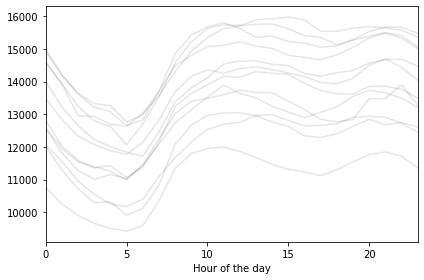

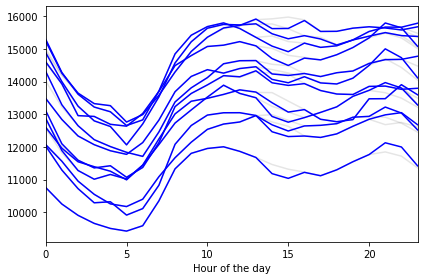

In [10]:
# plot all meters in study (combined into a single load profile)
frame288_type = "total_frame288"

# plot all meters combined before battery
plot_frame288(multi.aggregate_pre_intervalframe.total_frame288)
# compare all meteres combined after battery with before battery
plot_many_frame288s(
    [getattr(multi.aggregate_pre_intervalframe, frame288_type)],
    getattr(multi.aggregate_post_intervalframe, frame288_type),
)

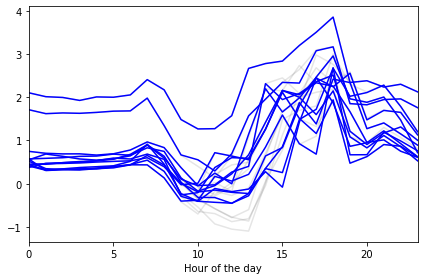

None

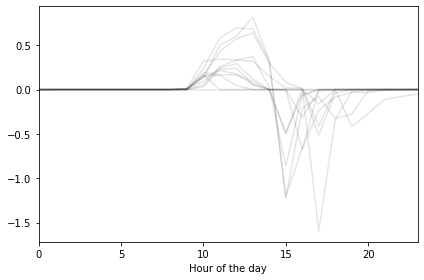

None

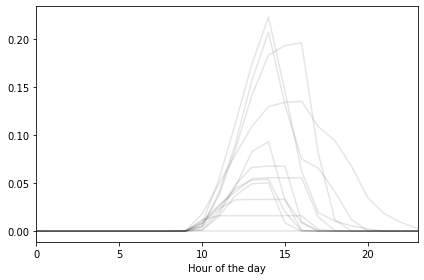

None

In [11]:
sa_id = 0

# examine battery operations for a single meter
battery_simulation = multi.battery_simulations.get(meter__sa_id=sa_id)
battery_intervalframe = battery_simulation.simulation.battery_intervalframe

# display average daily load before battery
display(plot_many_frame288s(
    [battery_simulation.pre_intervalframe.average_frame288],
    battery_simulation.post_intervalframe.average_frame288
))

# display average battery discharge
battery_intervalframe.aggregation_column = "kw"
display(plot_frame288(battery_intervalframe.average_frame288))

# display average battery state of charge
battery_intervalframe.aggregation_column = "charge"
charge_frame288 = battery_intervalframe.average_frame288
battery_intervalframe.aggregation_column = "capacity"
capacity_frame288 = battery_intervalframe.average_frame288
display(plot_frame288(charge_frame288/capacity_frame288))

In [12]:
# view individual before and after bills
bill_calculation = multi.bill_calculations.get(battery_simulation__meter__sa_id=sa_id)
bill_comparison = bill_calculation.bill_comparisons.get(start=datetime(2018, 7, 1))

display(bill_comparison.pre_DER_validation_bill.total_dataframe)
display(bill_comparison.post_DER_validation_bill.total_dataframe)

,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,energy,Energy Charge - Summer Peak,0,353.433,kWh,0.212,$/kWh,1,74.927796
1,energy,Energy Charge - Summer Part-Peak,1,25.028,kWh,0.07,$/kWh,1,1.751960
2,energy,Energy Charge - Summer Off-Peak,2,148.446,kWh,0.022,$/kWh,1,3.265812
Total,,,,526.907,,,,,79.945568


,category,description,tou_period,count,count_unit,rate,rate_unit,pro_rata,total
0,energy,Energy Charge - Summer Peak,0,292.533,kWh,0.212,$/kWh,1,62.016996
1,energy,Energy Charge - Summer Part-Peak,1,71.278,kWh,0.07,$/kWh,1,4.989460
2,energy,Energy Charge - Summer Off-Peak,2,170.896,kWh,0.022,$/kWh,1,3.759712
Total,,,,534.707,,,,,70.766168


In [13]:
# view individual before and after monthly GHG emissions
ghg_calculation = multi.ghg_calculations.get(battery_simulation__meter__sa_id=sa_id, ghg_rate__name="Clean Net Short", ghg_rate__effective__year=2030)
display(ghg_calculation.aggregate_ghg_calculation.comparison_table)

,before,after
1,0.511071,0.511071
2,0.347845,0.344213
3,0.225872,0.217595
4,0.170487,0.163733
5,0.161172,0.159260
6,0.146498,0.131384
7,0.235341,0.208547
8,0.215508,0.200087
9,0.228950,0.216507
10,0.251416,0.240776
